In [1]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os


test set: https://forums.fast.ai/t/how-to-add-a-test-set/38956/7
text.data reference methods: https://docs.fast.ai/text.html

In [2]:
data = pd.read_csv("category_features_1.csv")

In [3]:
df = pd.DataFrame({'label':data.label, 'text':data.text})

In [4]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")
import nltk 

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

#remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [5]:

detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
df['text'] = detokenized_doc

In [6]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3, random_state = 12)
df_trn.shape, df_val.shape

((33922, 2), (14539, 2))

In [7]:
#language model data - vectorization 
data_lm = TextLMDataBunch.from_df(train_df=df_trn, valid_df=df_val, path = "")

# Classifier model data - 
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)


In [8]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)


In [9]:
learn.lr_find(start_lr=1e-5, end_lr=10000)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [10]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.205281,3.298751,0.419286,00:33


In [11]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7)) #decrease learning rate by a factor of 10? why? 

epoch,train_loss,valid_loss,accuracy,time
0,3.120164,2.786084,0.492589,00:56
1,2.860427,2.530651,0.523973,01:00
2,2.652914,2.252985,0.555223,00:59
3,2.800378,3.082627,0.427009,01:00
4,2.697489,2.232222,0.557946,01:00
5,2.498211,2.067216,0.584107,01:00
6,2.313250,1.977242,0.600982,01:00
7,2.141997,1.939462,0.610268,01:00
8,1.994081,1.930158,0.613125,01:00
9,1.871184,1.926953,0.614152,01:00


In [12]:
learn.save_encoder('ft_enc_best')

In [13]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc_best')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


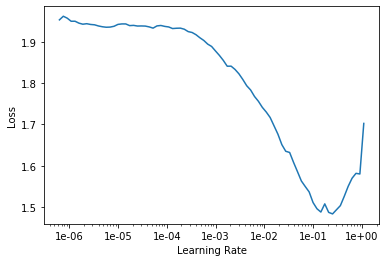

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn1 = learn
learn1.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn1.save('clas_first') 


epoch,train_loss,valid_loss,accuracy,time
0,1.330647,1.265105,0.632107,00:24


In [16]:
learn1.freeze_to(-2)
learn1.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))  #decrease learning rate by a factor of 10? 
learn1.save('clas_first_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.979164,0.864141,0.745819,00:30


In [17]:
learn1.freeze_to(-3)
learn1.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))  #decrease learning rate to middle of spike down? (factor of 10?)
learn1.save('clas_first_2')


epoch,train_loss,valid_loss,accuracy,time
0,0.733766,0.686382,0.775920,00:51


In [18]:
learn1.unfreeze()
learn1.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))  #decrease lr slightly further

epoch,train_loss,valid_loss,accuracy,time
0,0.561395,0.636294,0.792642,01:20


epoch,train_loss,valid_loss,accuracy,time
0,0.420209,0.947926,0.782609,01:19
1,0.432749,0.665847,0.829431,01:34
2,0.380062,0.612938,0.839465,01:35


In [21]:
learn1.save("pantry_with_ingred_model_1")

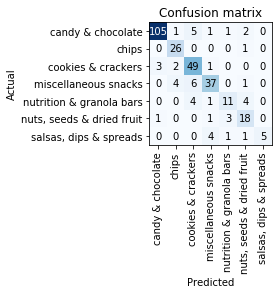

In [22]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [23]:
learn1.fit_one_cycle(1, 5e-3, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.332663,0.654988,0.839465,01:34


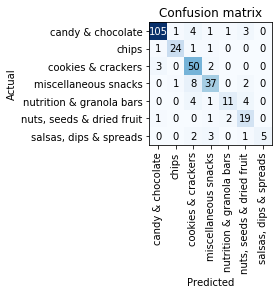

In [24]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	size mismatch for 0.module.encoder.weight: copying a param with shape torch.Size([544, 400]) from checkpoint, the shape in current model is torch.Size([1057, 400]).
	size mismatch for 0.module.encoder_dp.emb.weight: copying a param with shape torch.Size([544, 400]) from checkpoint, the shape in current model is torch.Size([1057, 400]).

In [26]:
learn1.predict("Planters Salted Caramel Nuts - 5oz")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([4.6762e-03, 2.3689e-04, 4.7700e-04, 6.5982e-03, 4.9677e-03, 9.8208e-01,
         9.6855e-04]))

In [27]:
learn1.predict("Planters NUT-rition Essential Nutrients Deluxe Nut Mix - 5.5oz")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([8.9710e-03, 2.7897e-04, 3.2380e-03, 1.4718e-01, 1.2531e-01, 7.0443e-01,
         1.0596e-02]))

In [28]:
learn1.predict("Gummi Worms - 7oz - Market Pantry™")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([0.1739, 0.0254, 0.0058, 0.0655, 0.0162, 0.7073, 0.0059]))

In [29]:
learn1.predict("HERSHEY'S Miniatures Party Bag Assorted Chocolate Candy Bars - 40oz")

(Category nutrition & granola bars,
 tensor(4),
 tensor([3.3130e-01, 7.0746e-05, 2.3203e-03, 7.9388e-03, 5.7535e-01, 5.4377e-02,
         2.8643e-02]))

In [30]:
learn1.predict("Dum Dums Original Assorted Flavors Lollipops - 1000ct")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([0.0453, 0.0019, 0.0012, 0.0167, 0.0069, 0.9247, 0.0033]))

In [31]:
learn1.predict("JOLLY RANCHER Original Flavors Hard Candies - 3.75lbs")

(Category nutrition & granola bars,
 tensor(4),
 tensor([0.0149, 0.0013, 0.0215, 0.2464, 0.4558, 0.2235, 0.0366]))

In [32]:
learn1.predict("Almonds, Peanuts & Sea Salt with Cocoa Drizzle Nut Bars - 12ct - Simply Balanced™")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([0.0378, 0.0007, 0.0080, 0.0319, 0.3625, 0.5534, 0.0058]))

In [33]:
learn1.predict("Kashi Dark Mocha Almond Chewy Granola Bars - 6ct")

(Category nutrition & granola bars,
 tensor(4),
 tensor([1.7183e-04, 1.0794e-06, 2.2061e-05, 1.1894e-04, 9.9563e-01, 3.7319e-03,
         3.2741e-04]))

In [34]:
learn1.predict("Organic Roasted Restaurant Style Salsa 24oz - Simply Balanced™")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([1.3523e-03, 1.4159e-04, 6.9513e-04, 9.4070e-03, 1.7058e-02, 9.7002e-01,
         1.3279e-03]))

In [35]:
learn1.predict("Pace® Mild Chunky Salsa 64 oz")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([0.1862, 0.0009, 0.0087, 0.1716, 0.1587, 0.4428, 0.0312]))

In [36]:
learn1.predict("Pepperidge Farm® Pirouette® Crème Filled Wafers Chocolate Hazelnut Cookies, 13.5oz Tin")

(Category candy & chocolate,
 tensor(0),
 tensor([0.5642, 0.0133, 0.0664, 0.1514, 0.0623, 0.1347, 0.0076]))

In [37]:
learn1.predict("Milkmakers Oatmeal Chocolate Chip Cookies - 10ct")

(Category candy & chocolate,
 tensor(0),
 tensor([0.6976, 0.0066, 0.0829, 0.0211, 0.1131, 0.0689, 0.0098]))

In [38]:
learn1.predict("Skinny Pop Popcorn 100 Calorie Bags - 24ct")

(Category miscellaneous snacks,
 tensor(3),
 tensor([0.0062, 0.0109, 0.0087, 0.6484, 0.0675, 0.2502, 0.0082]))

Keep in mind:
    - preprocess the input data the exact same way
    - might want to hardcode, create list of edge case brands/items that can't be predicted well
    - might want to generate data for edge case subtypes
    - try weighting in the future (concatenate data within python to manage this as a hyperparameter)